# Process Mining Assignment
### Decision Miner

#### Group 3

**Members**
- Marit Bosch
- Tristán Gonzalez Fernandez
- Max de Leeuw
- Steven Verbeek
- Sterre van Zutphen

---

### Imports & Datasets

In [69]:
import pm4py
import pandas as pd
from pm4py.objects.log.importer.xes import importer as xes_importer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


logs_Running_Examples = 'data/running-example.xes'
logs_Road_Traffic_Fine_Management_Process = 'data/Road_Traffic_Fine_Management_Process.xes'
logs_BPI_Challenge = 'data/BPI Challenge 2017.xes'

LOG = logs_Running_Examples

In [70]:
log = xes_importer.apply(LOG)

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

In [71]:
df = pm4py.convert_to_dataframe(log)

print("\n================= LOG SUMMARY =================\n")
print(f"Total traces: {len(log)}")
print(f"Total events: {len(df)}")
print(f"Log columns: {list(df.columns)}")



================= LOG SUMMARY =================

Total traces: 6
Total events: 42
Log columns: ['concept:name', 'org:resource', 'time:timestamp', 'Activity', 'Resource', 'Costs', 'case:concept:name', 'case:creator']


In [72]:
df.head()

,concept:name,org:resource,time:timestamp,Activity,Resource,Costs,case:concept:name,case:creator
0,register request,Pete,2010-12-30 14:32:00+00:00,register request,Pete,50,3,Fluxicon Nitro
1,examine casually,Mike,2010-12-30 15:06:00+00:00,examine casually,Mike,400,3,Fluxicon Nitro
2,check ticket,Ellen,2010-12-30 16:34:00+00:00,check ticket,Ellen,100,3,Fluxicon Nitro
3,decide,Sara,2011-01-06 09:18:00+00:00,decide,Sara,200,3,Fluxicon Nitro
4,reinitiate request,Sara,2011-01-06 12:18:00+00:00,reinitiate request,Sara,200,3,Fluxicon Nitro


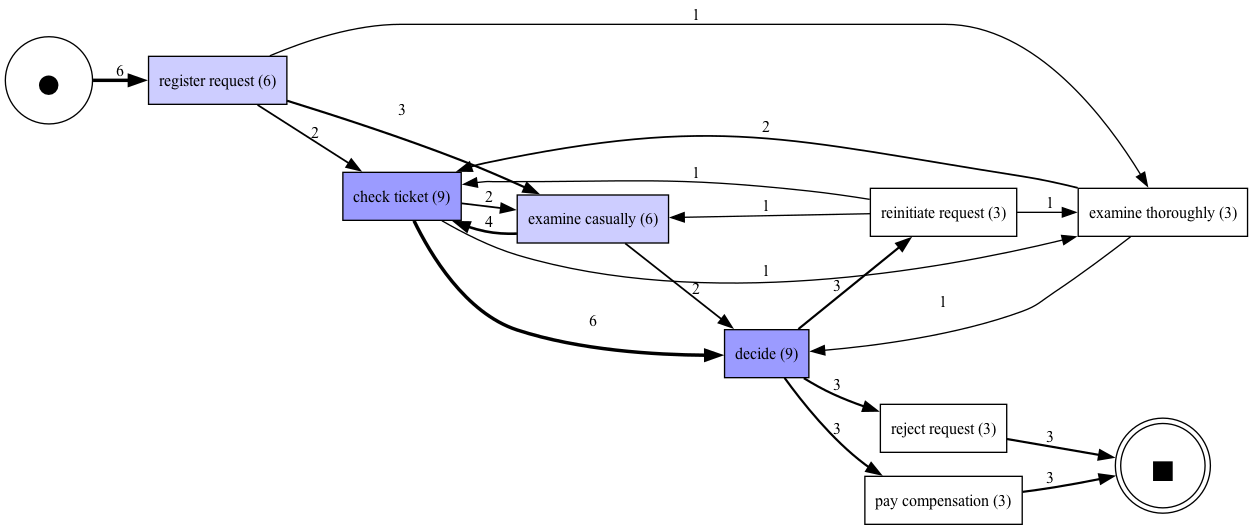

In [73]:
dfg, stat, end = pm4py.discover_dfg(log=log, case_id_key=1)
pm4py.view_dfg(dfg, stat, end)

In [74]:
def find_decision_points(petri):
    decision_points = {}
    for i, place in enumerate(petri.places):
        # outgoing transitions with labels
        outgoing_transitions = [arc.target for arc in petri.arcs if arc.source == place and getattr(arc.target, "label", None)]
        if len(outgoing_transitions) > 1:  # only decision points
            decision_points[len(decision_points)] = [t.label for t in outgoing_transitions]

    return decision_points

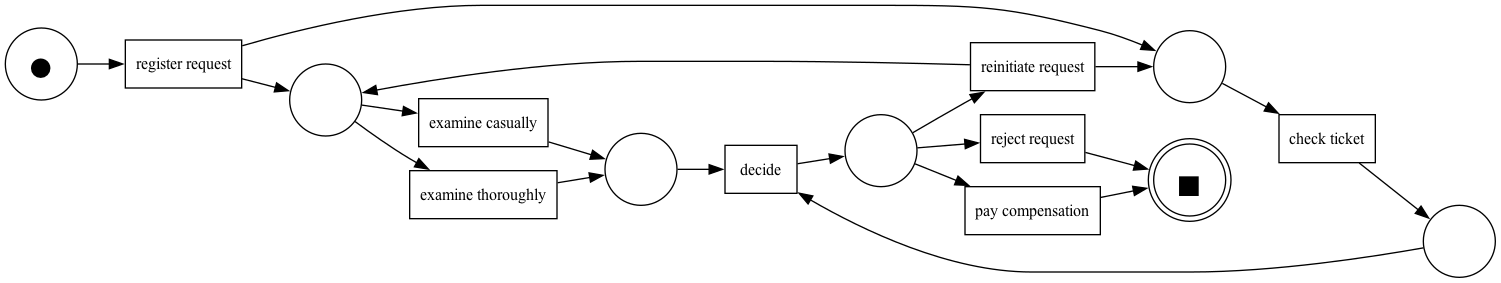

{0: ['examine casually', 'examine thoroughly'], 1: ['reject request', 'pay compensation', 'reinitiate request']}


In [75]:
petri_alpha, im_alpha, fm_alpha = pm4py.discover_petri_net_alpha(log=log)

pm4py.view_petri_net(petri_alpha, im_alpha, fm_alpha, log=log)


decision_points_alpha = find_decision_points(petri_alpha)
print(decision_points_alpha)

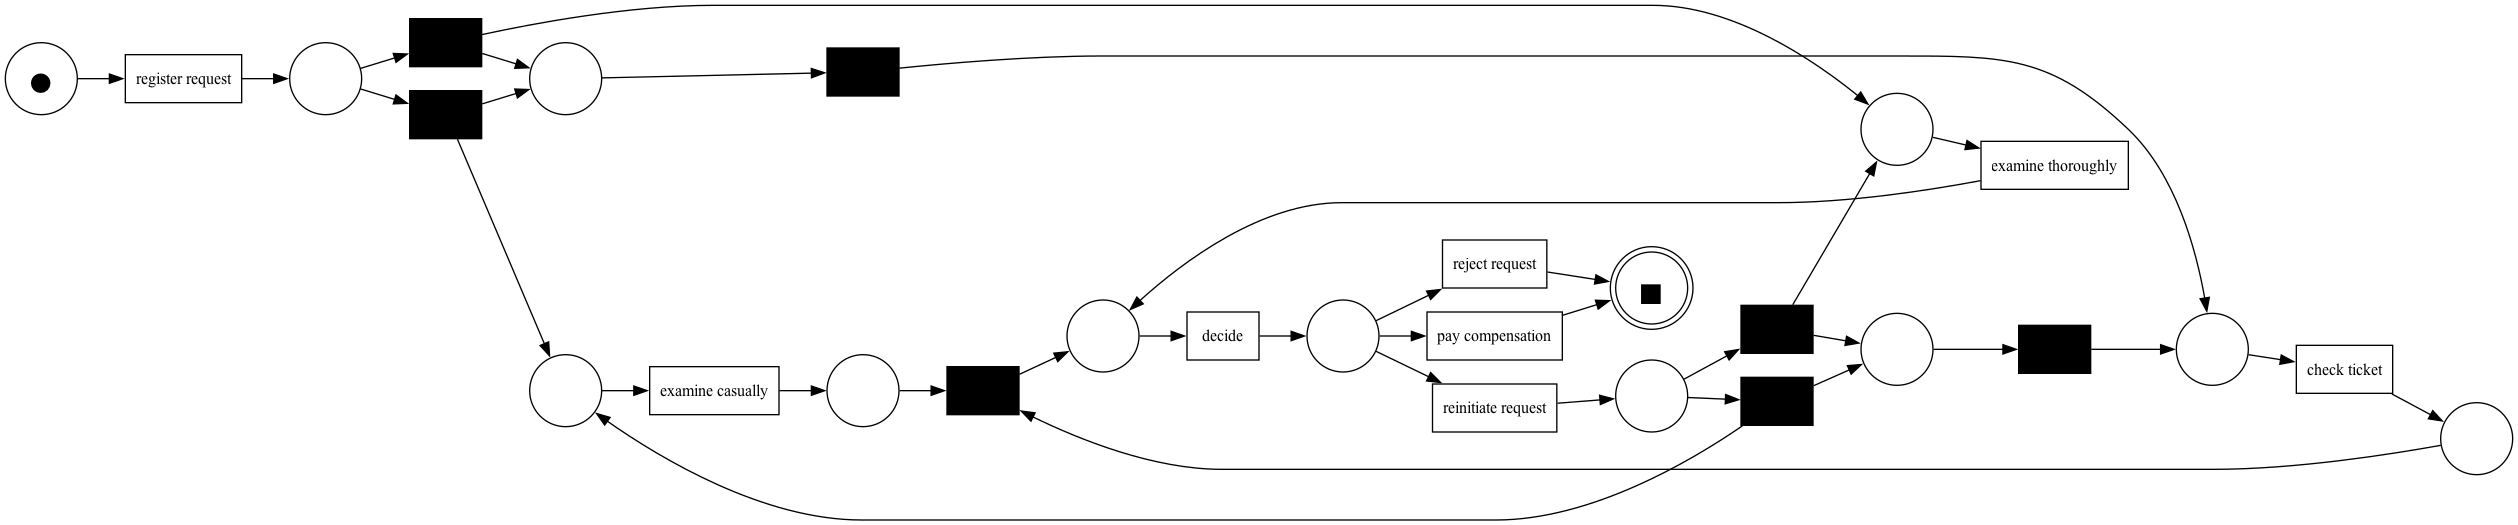

{0: ['pay compensation', 'reject request', 'reinitiate request']}


In [76]:
petri_heuristic, im_heuristic, fm_heuristic = pm4py.discover_petri_net_heuristics(log=log)

pm4py.view_petri_net(petri_heuristic, im_heuristic, fm_heuristic, log=log)


decision_points_heuristic = find_decision_points(petri_heuristic)
print(decision_points_heuristic)

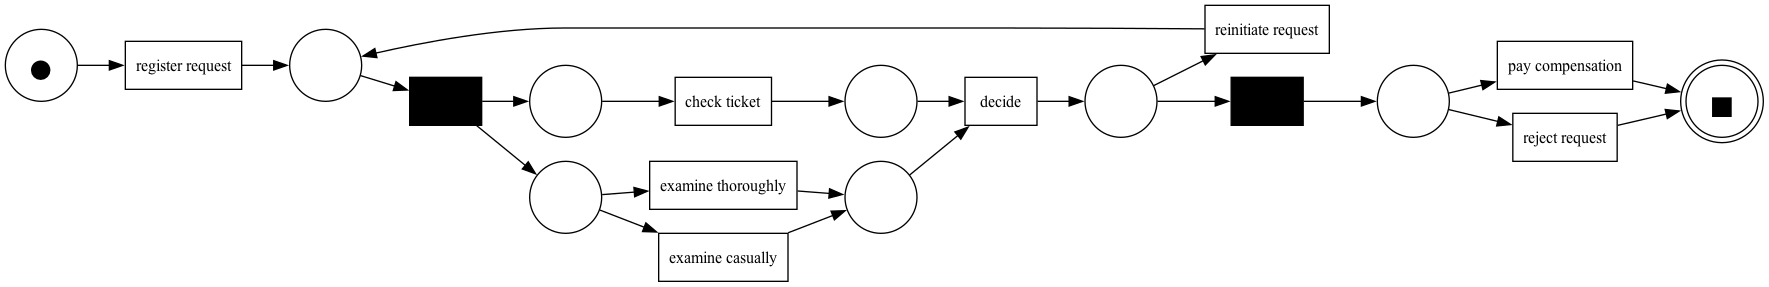

{0: ['reject request', 'pay compensation'], 1: ['examine casually', 'examine thoroughly']}


In [77]:
petri_inductive, im_inductive, fm_inductive = pm4py.discover_petri_net_inductive(log=log)

pm4py.view_petri_net(petri_inductive, im_inductive, fm_inductive, log=log)

decision_points_inductive = find_decision_points(petri_inductive)
print(decision_points_inductive)


In [78]:
petri = petri_alpha
decision_points = find_decision_points(petri)

print(decision_points)

{0: ['examine casually', 'examine thoroughly'], 1: ['reject request', 'pay compensation', 'reinitiate request']}


In [79]:
trace_length = 5
rows = []

for trace in log:
    case_id = trace.attributes.get('concept:name') or trace.attributes.get('case:concept:name')
    activity_trace = []  # store sequence of activities so far

    for idx, event in enumerate(trace):
        activity = event['concept:name']

        # Collect previous activities (up to trace_length)
        previous_activities = activity_trace[-trace_length:]  # last `trace_length` activities

        # Pad with None if fewer than trace_length
        previous_activities = [None]*(trace_length - len(previous_activities)) + previous_activities

        for dp_id, options in decision_points.items():
            if activity in options:
                row = {
                    "decision_point": dp_id,
                    "case_id": case_id,
                    "activity": activity,
                    "employee": event['org:resource'],
                    "timestamp": event['time:timestamp'],
                    "cost": event['Costs'],
                }

                # Add previous activities as separate columns
                for i in range(trace_length):
                    row[f'previous_activity_{i+1}'] = previous_activities[i]

                rows.append(row)

        # update activity sequence
        activity_trace.append(activity)

df_decision_full = pd.DataFrame(rows)
df_decision_full

,decision_point,case_id,activity,employee,timestamp,cost,previous_activity_1,previous_activity_2,previous_activity_3,previous_activity_4,previous_activity_5
0,0,3,examine casually,Mike,2010-12-30 15:06:00+00:00,400,None,None,None,None,register request
1,1,3,reinitiate request,Sara,2011-01-06 12:18:00+00:00,200,None,register request,examine casually,check ticket,decide
2,0,3,examine thoroughly,Sean,2011-01-06 13:06:00+00:00,400,register request,examine casually,check ticket,decide,reinitiate request
3,1,3,pay compensation,Ellen,2011-01-15 10:45:00+00:00,200,decide,reinitiate request,examine thoroughly,check ticket,decide
4,0,2,examine casually,Sean,2010-12-30 14:16:00+00:00,400,None,None,None,register request,check ticket
5,1,2,pay compensation,Ellen,2011-01-08 12:05:00+00:00,200,None,register request,check ticket,examine casually,decide
6,0,1,examine thoroughly,Sue,2010-12-31 10:06:00+00:00,400,None,None,None,None,register request
7,1,1,reject request,Pete,2011-01-07 14:24:00+00:00,200,None,register request,examine thoroughly,check ticket,decide
8,0,6,examine casually,Ellen,2011-01-06 16:06:00+00:00,400,None,None,None,None,register request
9,1,6,pay compensation,Mike,2011-01-16 11:47:00+00:00,200,None,register request,examine casually,check ticket,decide


In [80]:
decision_point_trees = {}

for dp_id, df_dp in df_decision_full.groupby("decision_point"):
    # Features
    exclude_cols = ['case_id', 'activity', 'decision_point']
    X = df_dp[[c for c in df_dp.columns if c not in exclude_cols]].fillna('None')

    # Convert to strings for LabelEncoder
    for col in X.columns:
        X[col] = X[col].astype(str)

    # Encode features
    le_dict = {}
    for col in X.columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        le_dict[col] = le

    # Encode label
    y = df_dp['activity'].astype(str)
    le_y = LabelEncoder()
    y_encoded = le_y.fit_transform(y)

    # Train Decision Tree
    clf = DecisionTreeClassifier(max_depth=5, random_state=42)
    clf.fit(X, y_encoded)

    # Store classifier and encoders
    decision_point_trees[dp_id] = {
        "clf": clf,
        "feature_encoders": le_dict,
        "label_encoder": le_y,
        "features": X.columns.tolist()
    }

print(f"Trained Decision Trees for {len(decision_point_trees)} decision points")

Trained Decision Trees for 2 decision points


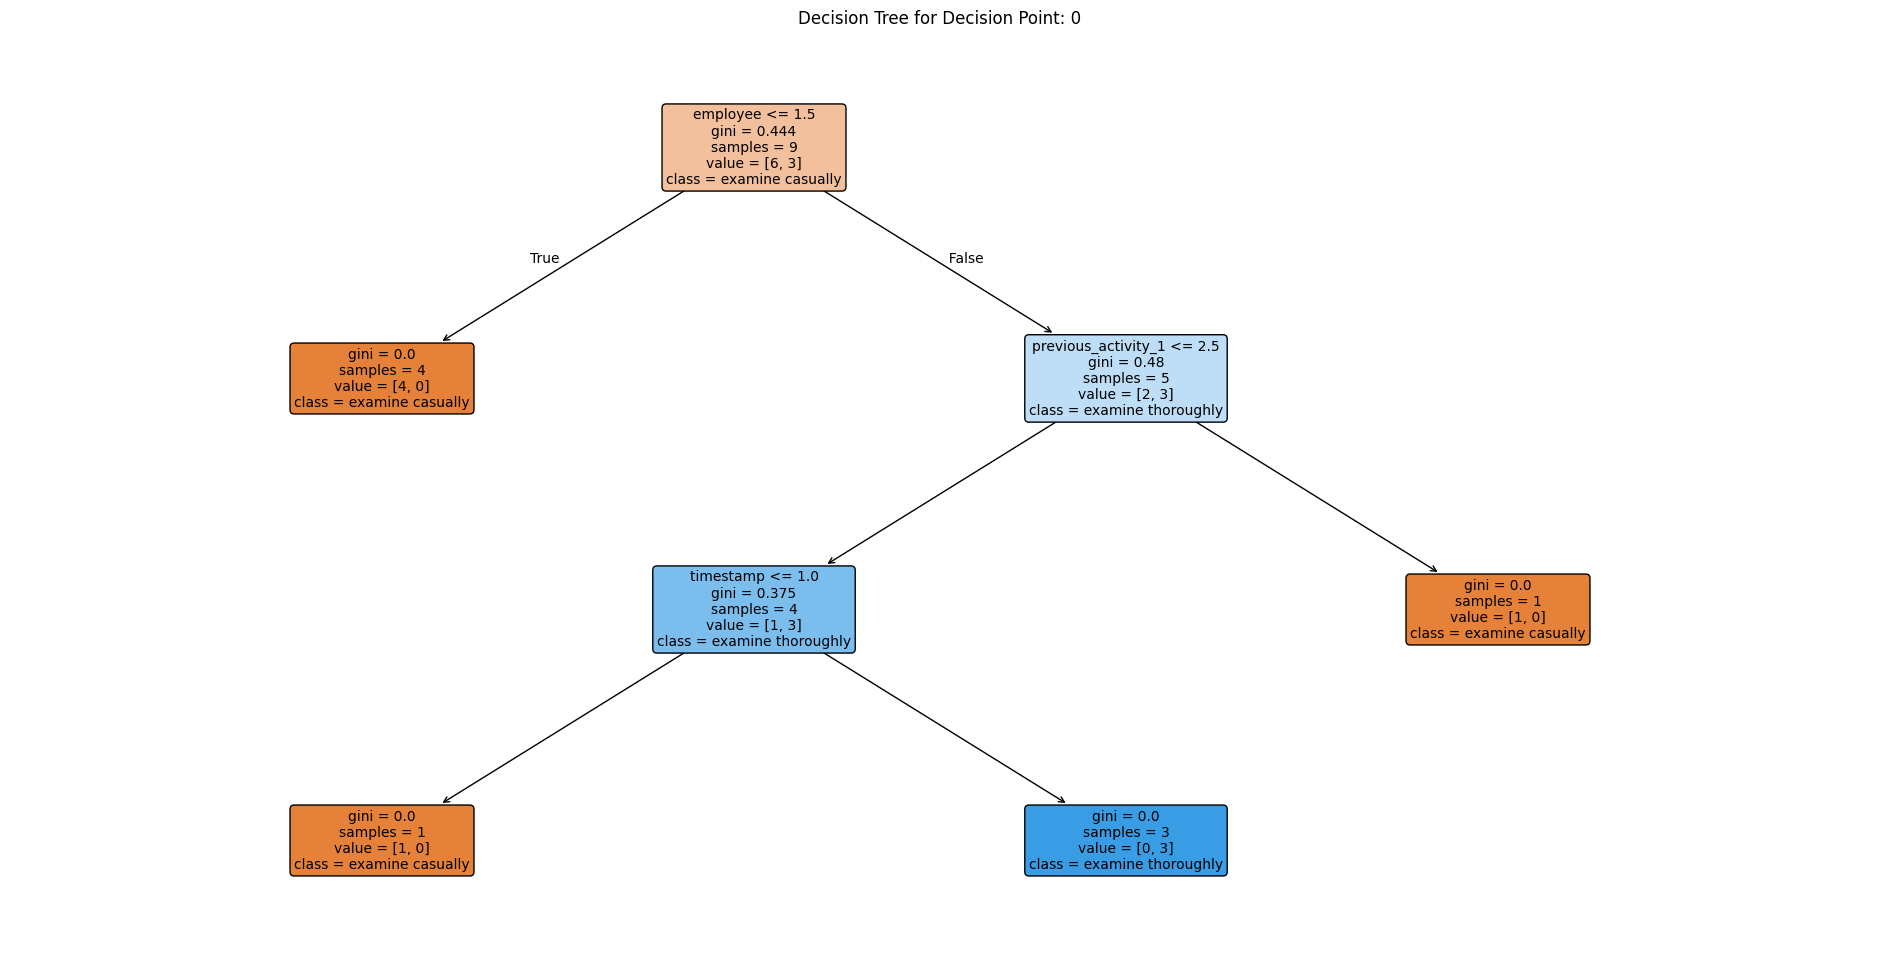

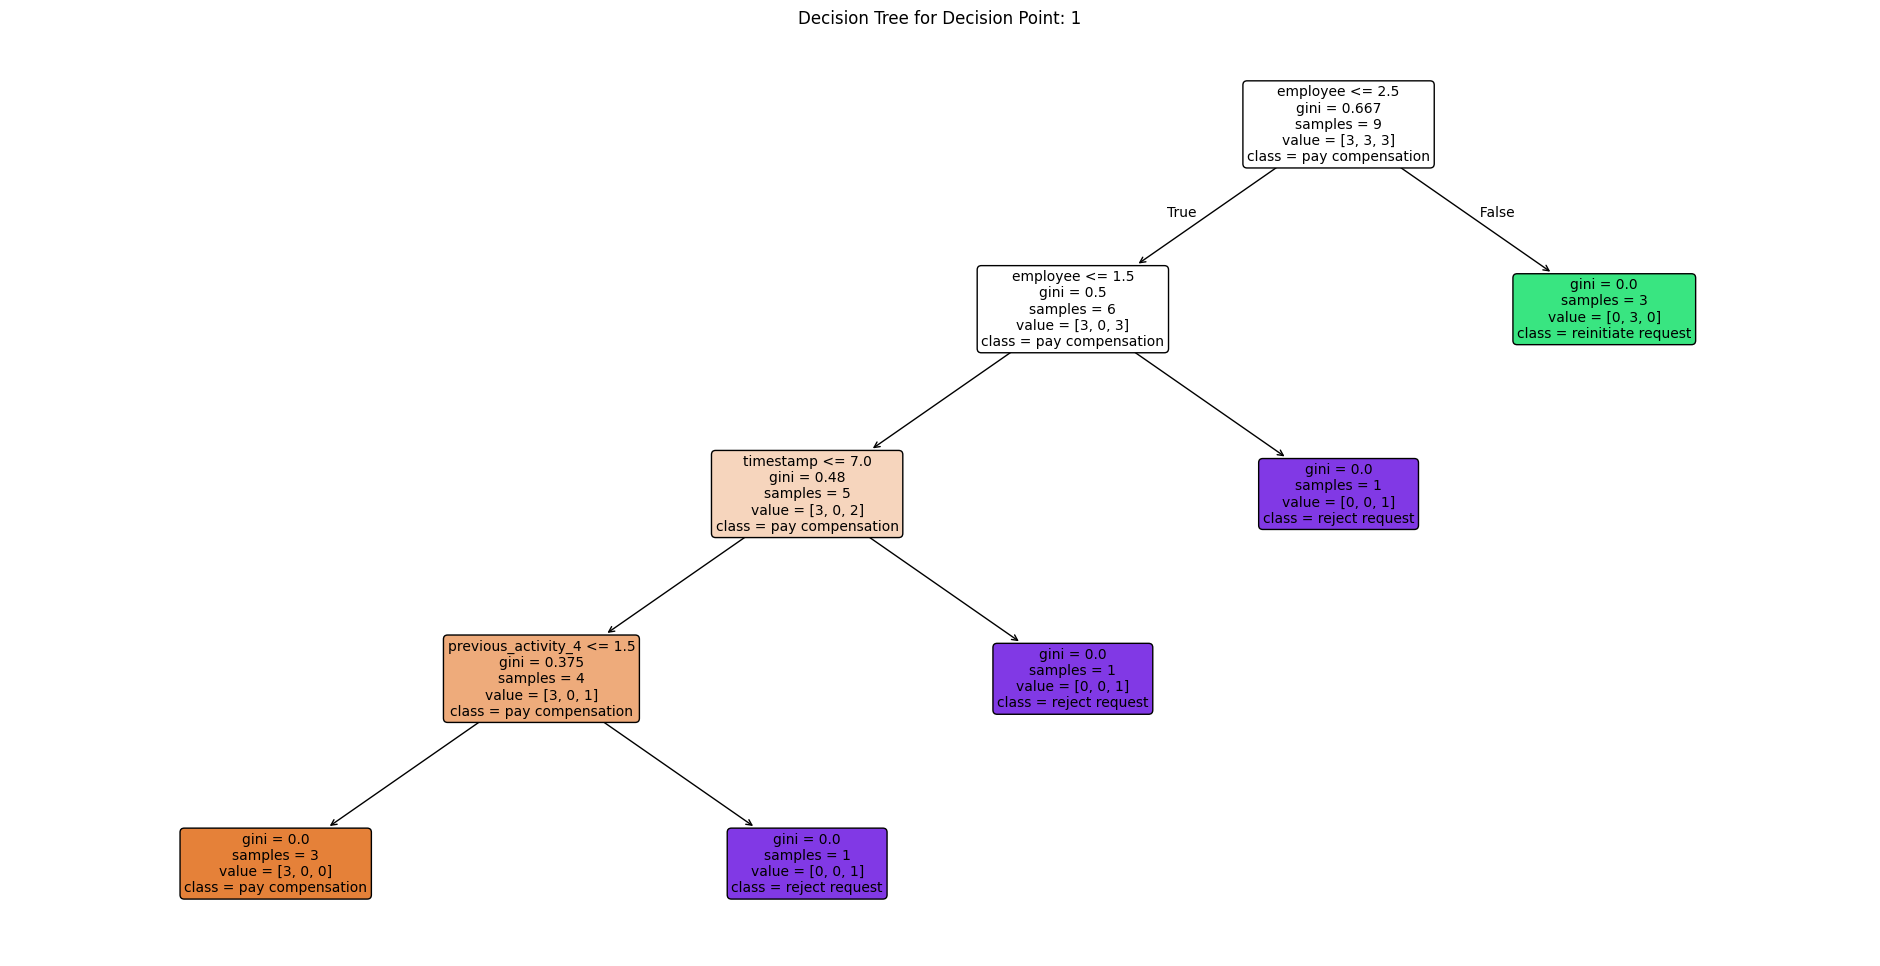

In [81]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

for dp_id, dp_data in decision_point_trees.items():
    clf = dp_data["clf"]
    feature_names = dp_data["features"]
    label_encoder = dp_data["label_encoder"]

    plt.figure(figsize=(24, 12))
    plot_tree(
        clf,
        feature_names=feature_names,
        class_names=label_encoder.classes_,
        filled=True,
        rounded=True,
        fontsize=10
    )
    plt.title(f"Decision Tree for Decision Point: {dp_id}")
    plt.show()

In [82]:
from sklearn.tree import export_text

from sklearn.tree import export_text

def readable_tree(dp_id, dp_data):
    clf = dp_data["clf"]
    feature_names = dp_data["features"]
    feature_encoders = dp_data.get("feature_encoders", {})
    label_encoder = dp_data.get("label_encoder", None)

    # Get the raw text rules
    rules = export_text(clf, feature_names=feature_names)

    # Replace numeric thresholds with categorical names
    for feature, le in feature_encoders.items():
        for i, cls in enumerate(le.classes_):
            # Replace "feature <= i.5" with "feature in ['cls']"
            rules = rules.replace(f"{feature} <= {i + 0.5}", f"{feature} == '{cls}'")
            # Replace "feature > i.5" with "feature in [next_class,...]"
            if i + 1 < len(le.classes_):
                next_classes = "', '".join(le.classes_[i+1:])
                rules = rules.replace(f"{feature} > {i + 0.5}", f"{feature} in ['{next_classes}']")
            else:
                rules = rules.replace(f"{feature} > {i + 0.5}", f"{feature} != '{cls}'")

    # Replace target indices with class names
    if label_encoder is not None:
        for i, cls in enumerate(label_encoder.classes_):
            rules = rules.replace(f"class: {i}", f"class: '{cls}'")

    print(f"\n{'='*80}\nDecision Point: {dp_id}\n{'='*80}")
    print(rules)

# Example usage:
for dp_id, dp_data in decision_point_trees.items():
    readable_tree(dp_id, dp_data)


Decision Point: 0
|--- employee == 'Mike'0
|   |--- class: 'examine casually'
|--- employee >  1.50
|   |--- previous_activity_1 == 'register request'0
|   |   |--- timestamp <= 1.00
|   |   |   |--- class: 'examine casually'
|   |   |--- timestamp >  1.00
|   |   |   |--- class: 'examine thoroughly'
|   |--- previous_activity_1 >  2.50
|   |   |--- class: 'examine casually'


Decision Point: 1
|--- employee == 'Pete'0
|   |--- employee == 'Mike'0
|   |   |--- timestamp <= 7.00
|   |   |   |--- previous_activity_4 == 'examine casually'0
|   |   |   |   |--- class: 'pay compensation'
|   |   |   |--- previous_activity_4 >  1.50
|   |   |   |   |--- class: 'reject request'
|   |   |--- timestamp >  7.00
|   |   |   |--- class: 'reject request'
|   |--- employee >  1.50
|   |   |--- class: 'reject request'
|--- employee >  2.50
|   |--- class: 'reinitiate request'

